In [1]:
import matplotlib.pyplot as plt
import time
import torch
from torch import logsumexp
from torch.distributions.normal import Normal
import numpy as np
from utils import *
from plots import *
from objectives import *

In [4]:
iterations = 30000
num_samples = 100
p_mu = 0.0
p_sigma2 = 1.0

LEARNING_RATE = 1e-3
log_Z = np.log(np.sqrt((2*np.pi)))

q_mu = torch.tensor([6.0], requires_grad=True)
q_sigma = torch.tensor([2.0], requires_grad=True)


optimizer = torch.optim.SGD([q_mu, q_sigma], lr=LEARNING_RATE)

In [5]:
EUBO, ELBO, Mu, Sigma, Grad_mu, Grad_sigma, ESS = dreg(num_samples, q_mu, q_sigma, p_mu, p_sigma2, iterations, optimizer, alpha=1)
# EUBOsmo, ELBOsmo = exp_average(EUBO, ELBO, iterations, beta1=0.9, beta2=0.999)

iteration:0, EUBO:4.350, ELBO:-0.175, ESS:1.024 (0s)
iteration:1000, EUBO:3.181, ELBO:1.116, ESS:11.299 (0s)
iteration:2000, EUBO:2.685, ELBO:1.084, ESS:17.419 (0s)
iteration:3000, EUBO:2.495, ELBO:1.023, ESS:19.614 (0s)
iteration:4000, EUBO:2.475, ELBO:1.094, ESS:22.028 (0s)
iteration:5000, EUBO:2.284, ELBO:1.240, ESS:30.519 (0s)
iteration:6000, EUBO:2.362, ELBO:1.246, ESS:29.324 (0s)
iteration:7000, EUBO:2.278, ELBO:0.992, ESS:24.110 (0s)
iteration:8000, EUBO:2.198, ELBO:0.811, ESS:21.569 (0s)
iteration:9000, EUBO:2.140, ELBO:1.129, ESS:31.434 (0s)
iteration:10000, EUBO:2.014, ELBO:1.050, ESS:32.969 (0s)
iteration:11000, EUBO:2.007, ELBO:0.922, ESS:29.221 (0s)
iteration:12000, EUBO:1.902, ELBO:0.839, ESS:30.769 (0s)
iteration:13000, EUBO:1.868, ELBO:0.822, ESS:30.186 (0s)
iteration:14000, EUBO:1.831, ELBO:1.061, ESS:40.724 (0s)
iteration:15000, EUBO:1.681, ELBO:0.782, ESS:35.074 (0s)
iteration:16000, EUBO:1.677, ELBO:0.811, ESS:36.003 (0s)
iteration:17000, EUBO:1.554, ELBO:0.867, ESS

In [6]:
eg_mu, eg2_mu, var_mu, snr_mu = SNR(np.array(Grad_mu), iterations, beta1=0.99, beta2=0.999)    
eg_sigma, eg2_sigma, var_sigma, snr_sigma = SNR(np.array(Grad_sigma), iterations, beta1=0.99, beta2=0.999)    


In [60]:
agrad_mu = - np.array(Mu) / (np.array(Sigma) ** 2)
agrad_sigma = ( 1 + np.array(Mu) ** 2) / (np.array(Sigma) ** 3) - 1. / np.array(Sigma)
##
eg_mu, eg2_mu, var_mu, snr_mu = SNR(agrad_mu, iterations, beta1=0.99, beta2=0.99)   
eg_sigma, eg2_sigma, var_sigma, snr_sigma = SNR(agrad_sigma, iterations, beta1=0.99, beta2=0.99)    

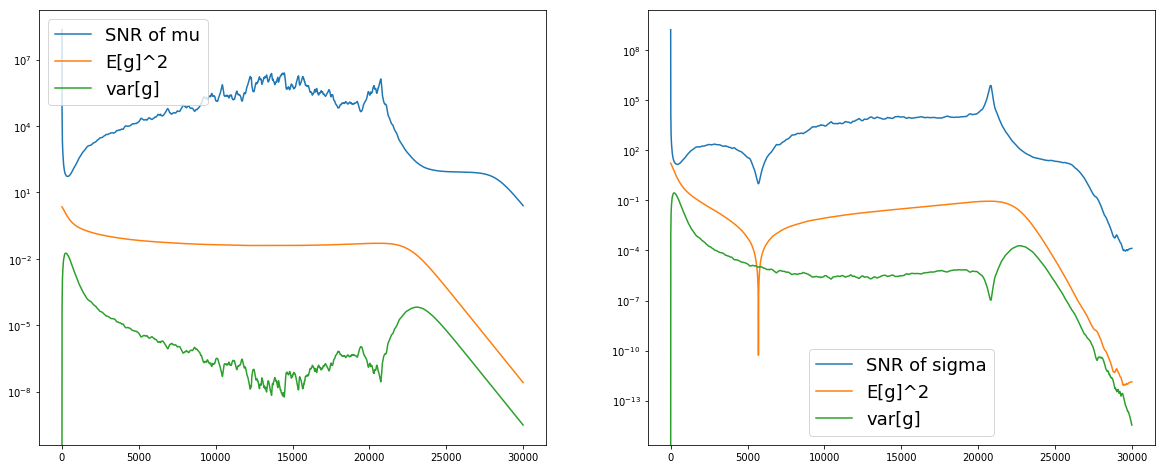

In [75]:
fig = plt.figure(figsize=(20,8))
ax1 = fig.add_subplot(1,2,1)
# ax1.plot(Grad_mu, alpha=0.3, label='gradient w.r.t. mu')
# ax1.plot(Mu, label='Mu')
# ax1.plot(agrad_mu, label='anlytical gradient w.r.t. mu')
ax1.plot(snr_mu, label='SNR of mu')
ax1.set_yscale('log')
ax1.plot(eg_mu ** 2, label='E[g]^2')
ax1.plot(var_mu, label='var[g]')
ax1.legend(fontsize=18)
# ax1.set_ylim([0.0, 1.0])

ax2 = fig.add_subplot(1,2,2)
ax2.set_yscale('log')
# ax2.plot(Grad_sigma, alpha=0.3, label='gradient w.r.t. sigma')
# ax2.plot(Sigma, label='Sigma')
# ax2.plot(agrad_sigma, label='anlytical gradient w.r.t. sigma')
ax2.plot(snr_sigma, label='SNR of sigma')
ax2.plot(eg_sigma ** 2, label='E[g]^2')
ax2.plot(var_sigma, label='var[g]')
ax2.legend(fontsize=18)
# ax2.set_ylim([-1.0, 5.0])

In [53]:
var_mu[15000:20000]

array([-0.00020886, -0.00020997, -0.00021112, ..., -0.00231754,
       -0.0023171 , -0.00231663])

In [36]:
3 ** 3

27

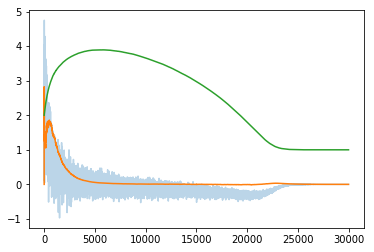

In [21]:
N = len(Grad_sigma)
plt.plot(Grad_sigma, alpha=0.3)
# plt.yscale('log')
# plt.plot(eg2_sigma)
plt.plot(var_sigma)
plt.plot(Sigma)

# plt.plot(eg2_sigma / (var_sigma))
# plt.ylim([1e0, 1e2])

In [ ]:
def plot_results(EUBO, ELBO, ESS, num_samples, snr_mu, snr_sigma):
    fig = plt.figure(figsize=(20,20))
    ax1, ax2, ax3 = fig.subplots(3, 1, sharex=True)
    plt.tight_layout()
    ax2.set_yscale('log')
    ax1.plot(EUBO, 'r', label='EUBOs')
    ax1.plot(ELBO, 'b', label='ELBOs')
    ax1.legend()
    ## SNR
    ax2.plot(snr_sigma, label='SNR_sigma')
    ax2.plot(snr_mu, label='SNR_mu')
    ax2.legend()
    ax2.set_ylim([1e-1,1e2])
    ## ESS
    ess_ratio = np.array(ESS) / num_samples
    ave_ess = np.reshape(ess_ratio, (-1, 10)).mean(-1)
    N = ave_ess.shape[0]
    ax3.plot(np.arange(N) * 10, ave_ess, 'go', label='ESS')
    ax3.set_ylim([0, 1])
plot_results(EUBO, ELBO, ESS, num_samples, snr_mu, snr_sigma)